In [1]:
from model_suggestor import ModelSuggestor
from typing import Dict, List, Tuple
from dotenv import load_dotenv
import guidance
import os
import re

load_dotenv()

api_key = os.getenv("api_key")
organization = os.getenv("organization")

# set the default language model used to execute guidance programs
gpt4 = guidance.llms.OpenAI(api_key=api_key, organization=organization, model="gpt-4")
gpt3 = guidance.llms.OpenAI(api_key=api_key, organization=organization, model="gpt-3.5-turbo-16k")
davinci = guidance.llms.OpenAI(api_key=api_key, organization=organization, model="text-davinci-003")
davinci2 = guidance.llms.OpenAI(api_key=api_key, organization=organization, model="davinci")

In [11]:
modeler = ModelSuggestor()

In [2]:
import pandas as pd
import numpy as np

variable_names = [
    "sleep_quality", 
    "heart_rate_variability", 
    "age", 
    "income_level", 
    "residential_area", 
    "medication", 
    "physical_activity_level", 
    "mental_stress_level", 
    "occupational_stress_level", 
    "ambient_temperature",
    "sleep_hygiene_practices",
    "chronic_health_conditions", 
    "menstrual_cycle_phase", 
    "health_status", 
    "lifestyle_factors", 
    "caffeine_consumption", 
    "nutritional_status", 
    "gender", 
    "education_level", 
]

# Create an empty DataFrame with the specified column names
df = pd.DataFrame(columns=variable_names)

# # Generate some sample data
# sample_data = np.random.randn(10, len(variable_names))

# # Populate the DataFrame with the sample data
# df = pd.DataFrame(sample_data, columns=variable_names)

# Set the data type of each column to float
df = df.astype(float)

variables_and_datatypes : Dict[str, str] = {}

# Iterate over the columns and their corresponding datatypes
for column, datatype in df.items():
    variables_and_datatypes[column] = datatype.dtype

for key, value in variables_and_datatypes.items():
    print(f"{key}: {value}\n")

sleep_quality: float64

heart_rate_variability: float64

age: float64

income_level: float64

residential_area: float64

medication: float64

physical_activity_level: float64

mental_stress_level: float64

occupational_stress_level: float64

ambient_temperature: float64

sleep_hygiene_practices: float64

chronic_health_conditions: float64

menstrual_cycle_phase: float64

health_status: float64

lifestyle_factors: float64

caffeine_consumption: float64

nutritional_status: float64

gender: float64

education_level: float64



In [13]:
import dodiscover as dd

In [14]:
variables_and_descriptions = modeler.suggest_descriptions(variable_names=variable_names, llm=gpt4)

Stop program system You are a helpful assistant with expertise in causal inference. You are helping me better understand a dataset by providing me with a description of the variables. I will provide you with the name of a column variable within the dataset and you will provide a description for that column variable. Let's take it step by step to make sure the description is relevant, succinct, and clear. 
 Here is an example:
 ------------------------------------------
 variable_name
 description
 ------------------------------------------
 age
 The age of the patient in years. user education_level assistant The highest level of education attained by the individual, usually categorized into groups such as high school, college, post-graduate, etc.

In [15]:
for variable, description in variables_and_descriptions.items():
    print(f"{variable}: {description}")

sleep_quality: The subjective rating of the individual's quality of sleep, typically measured on a scale (for example 1-5, with 1 being poor quality and 5 being excellent).
heart_rate_variability: The variability in the time interval between consecutive heartbeats in milliseconds. This can be used as a measure of the body's autonomic nervous system function and stress level.
age: The age of the individual or subject in the dataset, typically measured in years.
income_level: The income level of the individual, typically categorized into ranges like low, middle, and high, based on their total annual income.
residential_area: The residential area where the individual or subject of the study lives, typically categorized by urban, suburban, or rural settings.
medication: The type or name of the medication that the patient is currently taking or has been prescribed.
physical_activity_level: The level of physical activity performed by the individual, often categorized into levels such as low,

In [16]:
treatment="sleep_quality"
outcome="heart_rate_variability"

In [17]:
latent_variables_explanation = modeler.suggest_latent_confounders(variables_and_descriptions=variables_and_descriptions, treatment=treatment, outcome=outcome, llm=gpt4)

Stop program system You are a helpful assistant with expertise in causal inference. Given a relationship of interest between a treatment variable, an outcome variable, and a list of confounders, your task is to identify confounders missing from this list. 

 To be included as a confounder, a variable must satisfy the following conditions:

 1. The variable directly causes the treatment assignment.
 2. The variable directly causes the outcome of interest.
 3. The variable is not affected/caused by the treatment itself.
 4. The variable is not affected/caused by the outcome itself.
 5. The variable is not on the causal pathway between the treatment and the outcome.

 Given a list of variables under consideration for the list of confounders, your task is to identify confounders missing from this list. 
 These confounders should be variables that, if unaccounted for, could lead to biased or incorrect estimates of the causal effect. Your response should include a list of these variables and an explanation of why they are considered confounders. 
 ------------------------------------------
 Input:
 treatment
 treatment_variable_name
 description of treatment_variable

 outcome
 outcome_variable_name
 description of outcome_variable

 variables under consideration
 name_of_first_variable: Description of first variable.
 name_of_second_variable: Description of second variable.
 ...
 name_of_nth_confounder: Description of nth variable. 

 Output: 
 <confounder>name_of_first_variable</confounder>: <explanation>Description of nth variable. 
 Explanation for why and how the selected variable is or is not a confounder.</explanation>

 ...

 <confounder>name_of_nth_confounder</confounder>: <explanation>Description of nth variable. 
 Explanation for why and how the selected variable is or is not a confounder.</explanation> user Treatment: sleep_quality 
 Outcome: heart_rate_variability 

 Dataset schema with descriptions
 {'sleep_quality': "The subjective rating of the individual's quality of sleep, typically measured on a scale (for example 1-5, with 1 being poor quality and 5 being excellent).", 'heart_rate_variability': "The variability in the time interval between consecutive heartbeats in milliseconds. This can be used as a measure of the body's autonomic nervous system function and stress level.", 'age': 'The age of the individual or subject in the dataset, typically measured in years.', 'income_level': 'The income level of the individual, typically categorized into ranges like low, middle, and high, based on their total annual income.', 'residential_area': 'The residential area where the individual or subject of the study lives, typically categorized by urban, suburban, or rural settings.', 'medication': 'The type or name of the medication that the patient is currently taking or has been prescribed.', 'physical_activity_level': 'The level of physical activity performed by the individual, often categorized into levels such as low, moderate, or high. This could be based on frequency, duration, and intensity of physical activities that the individual engages in.', 'mental_stress_level': 'The level of mental stress experienced by the individual, often measured on a numeric scale (e.g., 1-10 or 1-100), where higher numbers represent higher levels of stress.', 'occupational_stress_level': 'The level of stress experienced by the individual due to their occupation, typically measured on a scale.', 'ambient_temperature': 'The surrounding temperature of the environment measured in degrees Celsius or Fahrenheit.', 'sleep_hygiene_practices': "The habits and behaviors related to the individual's sleep quality and duration, which may include bedtime routine, sleep schedule, and sleep environment.", 'chronic_health_conditions': 'The number or type of long-term health conditions that the individual has, such as diabetes, heart disease, or cancer. These conditions typically require ongoing management over a period of years or decades.', 'menstrual_cyc

In [18]:
for confounder, explanation in latent_variables_explanation.items():
    print(f"{confounder}: {explanation}")

In [19]:
confounders_and_descriptions = modeler.suggest_confounders(variables_and_descriptions=variables_and_descriptions, llm=gpt4, treatment="sleep_quality", outcome="heart_rate_variability")

Stop program system You are a helpful assistant with expertise in causal inference. Given a relationship of interest between a treatment variable, an outcome variable and a list of potential confounders, your task is to identify confounders present in the list.

 To be included as a confounder, a variable must satisfy the following conditions:

 1. The variable directly causes the treatment assignment.
 2. The variable directly causes the outcome of interest.
 3. The variable is not affected/caused by the treatment itself.
 4. The variable is not affected/caused by the outcome itself.
 5. The variable is not on the causal pathway between the treatment and the outcome.

 You will be provided with a list of potential confounders, and your task is to identify variables that satisfy the above conditions, i.e. are confouding the relationship between the treatment and the outcome.
 These confounders should be variables that, if unaccounted for, could lead to biased or incorrect estimates of the causal effect. Your response should include a list of these variables and an explanation of why they are considered confounders. 
 ------------------------------------------
 Input:
 treatment
 treatment_variable_name
 description of treatment_variable

 outcome
 outcome_variable_name
 description of outcome_variable

 variables under consideration
 name_of_first_variable: Description of first variable.
 name_of_second_variable: Description of second variable.
 ...
 name_of_nth_confounder: Description of nth variable. 

 Output: 
 <confounder>name_of_first_variable</confounder>: <explanation>Description of nth variable. 
 Explanation for why and how the selected variable is or is not a confounder.</explanation>

 ...

 <confounder>name_of_nth_confounder</confounder>: <explanation>Description of nth variable. 
 Explanation for why and how the selected variable is or is not a confounder.</explanation> user Treatment: sleep_quality 
 Outcome: heart_rate_variability 

 Dataset schema with descriptions
 age: The age of the individual or subject in the dataset, typically measured in years., income_level: The income level of the individual, typically categorized into ranges like low, middle, and high, based on their total annual income., residential_area: The residential area where the individual or subject of the study lives, typically categorized by urban, suburban, or rural settings., medication: The type or name of the medication that the patient is currently taking or has been prescribed., physical_activity_level: The level of physical activity performed by the individual, often categorized into levels such as low, moderate, or high. This could be based on frequency, duration, and intensity of physical activities that the individual engages in., mental_stress_level: The level of mental stress experienced by the individual, often measured on a numeric scale (e.g., 1-10 or 1-100), where higher numbers represent higher levels of stress., occupational_stress_level: The level of stress experienced by the individual due to their occupation, typically measured on a scale., ambient_temperature: The surrounding temperature of the environment measured in degrees Celsius or Fahrenheit., sleep_hygiene_practices: The habits and behaviors related to the individual's sleep quality and duration, which may include bedtime routine, sleep schedule, and sleep environment., chronic_health_conditions: The number or type of long-term health conditions that the individual has, such as diabetes, heart disease, or cancer. These conditions typically require ongoing management over a period of years or decades., menstrual_cycle_phase: The stage of the menstrual cycle the female participant is currently in. This could include phases such as menstruation, follicular phase, ovulation, and luteal phase., health_status: The overall health condition of the individual, often categorized as 'excellent', 'good', 'fair', or 'poor'., lifestyle_factors: The lifestyle_factors column r

In [20]:
for confounder, description in confounders_and_descriptions.items():
    print(f"{confounder}: {description}")

In [21]:
relevant_relationships_and_descriptions = modeler.suggest_variable_relationships(variables_and_descriptions=variables_and_descriptions, latent_confounders_descriptions=confounders_and_descriptions, llm=gpt4)

Stop program system You are a helpful assistant with expertise in causal inference. Given two variables along with their description, your task is to identify which variable is the parent and which is the child. During your analysis, consider various causal factors to guide your assessment.
 ------------------------------------------
 Input:

 Dataset with descriptions
 name_of_first_variable: Description of first variable.
 ...
 name_of_nth_confounder: Description of nth variable. 

 Selected variables
 first_variable
 second_variable 

 Output (if there is a causal relationship):
 <parent>variable_a</parent>
 <child>variable_b</child>

 Output (if there is no causal relationship): 
 <null> user Selected variables
 education_level 
 caffeine_consumption 

 Does education_level directly cause caffeine_consumption ?
 Or does caffeine_consumption directly cause education_level ?
 Consider various causal factors to guide your assessment and only answer if you are confident in your response. assistant The causal relationship between these two variables is not straightforward. However, in most scenarios, it would be more logical to assume that one's "education_level" could influence their "caffeine_consumption" rather than the other way round. For instance, higher education levels may lead to more stressful jobs or work environments, potentially resulting in increased caffeine consumption. However, it's important to note that there may be many other confounding variables in this relationship.

Output:
<parent>education_level</parent>
<child>caffeine_consumption</child>

In [22]:
for relationship in relevant_relationships_and_descriptions:
    print(f"{relationship}") 

('sleep_quality', 'heart_rate_variability')
('age', 'sleep_quality')
('income_level', 'sleep_quality')
('residential_area', 'sleep_quality')
('medication', 'sleep_quality')
('physical_activity_level', 'sleep_quality')
('mental_stress_level', 'sleep_quality')
('occupational_stress_level', 'sleep_quality')
('ambient_temperature', 'sleep_quality')
('sleep_hygiene_practices', 'sleep_quality')
('chronic_health_conditions', 'sleep_quality')
('menstrual_cycle_phase', 'sleep_quality')
('sleep_quality', 'health_status')
('lifestyle_factors', 'sleep_quality')
('caffeine_consumption', 'sleep_quality')
('nutritional_status', 'sleep_quality')
('education_level', 'sleep_quality')
('age', 'heart_rate_variability')
('medication', 'heart_rate_variability')
('physical_activity_level', 'heart_rate_variability')
('mental_stress_level', 'heart_rate_variability')
('occupational_stress_level', 'heart_rate_variability')
('ambient_temperature', 'heart_rate_variability')
('sleep_hygiene_practices', 'heart_rate_

In [3]:
relationships = [('sleep_quality', 'heart_rate_variability'),
('age', 'sleep_quality'),
('income_level', 'sleep_quality'),
('residential_area', 'sleep_quality'),
('medication', 'sleep_quality'),
('physical_activity_level', 'sleep_quality'),
('mental_stress_level', 'sleep_quality'),
('occupational_stress_level', 'sleep_quality'),
('ambient_temperature', 'sleep_quality'),
('sleep_hygiene_practices', 'sleep_quality'),
('chronic_health_conditions', 'sleep_quality'),
('menstrual_cycle_phase', 'sleep_quality'),
('sleep_quality', 'health_status'),
('lifestyle_factors', 'sleep_quality'),
('caffeine_consumption', 'sleep_quality'),
('nutritional_status', 'sleep_quality'),
('education_level', 'sleep_quality'),
('age', 'heart_rate_variability'),
('medication', 'heart_rate_variability'),
('physical_activity_level', 'heart_rate_variability'),
('mental_stress_level', 'heart_rate_variability'),
('occupational_stress_level', 'heart_rate_variability'),
('ambient_temperature', 'heart_rate_variability'),
('sleep_hygiene_practices', 'heart_rate_variability'),
('chronic_health_conditions', 'heart_rate_variability'),
('menstrual_cycle_phase', 'heart_rate_variability'),
('heart_rate_variability', 'health_status'),
('lifestyle_factors', 'heart_rate_variability'),
('caffeine_consumption', 'heart_rate_variability'),
('nutritional_status', 'heart_rate_variability'),
('age', 'income_level'),
('age', 'medication'),
('age', 'physical_activity_level'),
('age', 'mental_stress_level'),
('age', 'occupational_stress_level'),
('age', 'sleep_hygiene_practices'),
('age', 'chronic_health_conditions'),
('age', 'menstrual_cycle_phase'),
('age', 'health_status'),
('age', 'lifestyle_factors'),
('age', 'caffeine_consumption'),
('age', 'nutritional_status'),
('age', 'education_level'),
('income_level', 'heart_rate_variability'),
('income_level', 'residential_area'),
('income_level', 'medication'),
('income_level', 'physical_activity_level'),
('income_level', 'mental_stress_level'),
('income_level', 'occupational_stress_level'),
('income_level', 'sleep_hygiene_practices'),
('income_level', 'chronic_health_conditions'),
('income_level', 'health_status'),
('income_level', 'lifestyle_factors'),
('income_level', 'caffeine_consumption'),
('income_level', 'nutritional_status'),
('education_level', 'income_level'),
('residential_area', 'heart_rate_variability'),
('residential_area', 'medication'),
('residential_area', 'physical_activity_level'),
('residential_area', 'mental_stress_level'),
('residential_area', 'occupational_stress_level'),
('residential_area', 'ambient_temperature'),
('residential_area', 'sleep_hygiene_practices'),
('residential_area', 'chronic_health_conditions'),
('residential_area', 'health_status'),
('residential_area', 'lifestyle_factors'),
('residential_area', 'nutritional_status'),
('education_level', 'residential_area'),
('physical_activity_level', 'medication'),
('mental_stress_level', 'medication'),
('occupational_stress_level', 'medication'),
('ambient_temperature', 'medication'),
('medication', 'sleep_hygiene_practices'),
('chronic_health_conditions', 'medication'),
('menstrual_cycle_phase', 'medication'),
('medication', 'health_status'),
('lifestyle_factors', 'medication'),
('medication', 'nutritional_status'),
('gender', 'medication'),
('physical_activity_level', 'mental_stress_level'),
('occupational_stress_level', 'physical_activity_level'),
('ambient_temperature', 'physical_activity_level'),
('physical_activity_level', 'sleep_hygiene_practices'),
('physical_activity_level', 'chronic_health_conditions'),
('physical_activity_level', 'menstrual_cycle_phase'),
('physical_activity_level', 'health_status'),
('lifestyle_factors', 'physical_activity_level'),
('caffeine_consumption', 'physical_activity_level'),
('physical_activity_level', 'nutritional_status'),
('education_level', 'physical_activity_level'),
('occupational_stress_level', 'mental_stress_level'),
('ambient_temperature', 'mental_stress_level'),
('mental_stress_level', 'sleep_hygiene_practices'),
('mental_stress_level', 'chronic_health_conditions'),
('mental_stress_level', 'menstrual_cycle_phase'),
('mental_stress_level', 'health_status'),
('mental_stress_level', 'lifestyle_factors'),
('mental_stress_level', 'caffeine_consumption'),
('mental_stress_level', 'nutritional_status'),
('education_level', 'mental_stress_level'),
('occupational_stress_level', 'sleep_hygiene_practices'),
('occupational_stress_level', 'chronic_health_conditions'),
('occupational_stress_level', 'menstrual_cycle_phase'),
('occupational_stress_level', 'health_status'),
('occupational_stress_level', 'lifestyle_factors'),
('occupational_stress_level', 'caffeine_consumption'),
('occupational_stress_level', 'nutritional_status'),
('education_level', 'occupational_stress_level'),
('ambient_temperature', 'occupational_stress_level'),
('ambient_temperature', 'sleep_hygiene_practices'),
('ambient_temperature', 'chronic_health_conditions'),
('ambient_temperature', 'health_status'),
('ambient_temperature', 'lifestyle_factors'),
('ambient_temperature', 'caffeine_consumption'),
('ambient_temperature', 'nutritional_status'),
('sleep_hygiene_practices', 'chronic_health_conditions'),
('sleep_hygiene_practices', 'health_status'),
('lifestyle_factors', 'sleep_hygiene_practices'),
('caffeine_consumption', 'sleep_hygiene_practices'),
('sleep_hygiene_practices', 'nutritional_status'),
('education_level', 'sleep_hygiene_practices'),
('chronic_health_conditions', 'menstrual_cycle_phase'),
('chronic_health_conditions', 'health_status'),
('lifestyle_factors', 'chronic_health_conditions'),
('caffeine_consumption', 'chronic_health_conditions'),
('chronic_health_conditions', 'nutritional_status'),
('education_level', 'chronic_health_conditions'),
('menstrual_cycle_phase', 'sleep_hygiene_practices'),
('menstrual_cycle_phase', 'health_status'),
('menstrual_cycle_phase', 'lifestyle_factors'),
('menstrual_cycle_phase', 'caffeine_consumption'),
('menstrual_cycle_phase', 'nutritional_status'),
('gender', 'menstrual_cycle_phase'),
('lifestyle_factors', 'health_status'),
('caffeine_consumption', 'health_status'),
('nutritional_status', 'health_status'),
('gender', 'health_status'),
('education_level', 'health_status'),
('lifestyle_factors', 'caffeine_consumption'),
('lifestyle_factors', 'nutritional_status'),
('education_level', 'lifestyle_factors'),
('caffeine_consumption', 'medication'),
('caffeine_consumption', 'nutritional_status'),
('nutritional_status', 'education_level'),
('gender', 'sleep_quality'),
('gender', 'heart_rate_variability'),
('gender', 'income_level'),
('gender', 'physical_activity_level'),
('gender', 'mental_stress_level'),
('gender', 'occupational_stress_level'),
('gender', 'sleep_hygiene_practices'),
('gender', 'chronic_health_conditions'),
('gender', 'lifestyle_factors'),
('gender', 'caffeine_consumption'),
('gender', 'nutritional_status'),
('gender', 'education_level'),
('education_level', 'heart_rate_variability'),
('education_level', 'medication'),
('education_level', 'caffeine_consumption')]

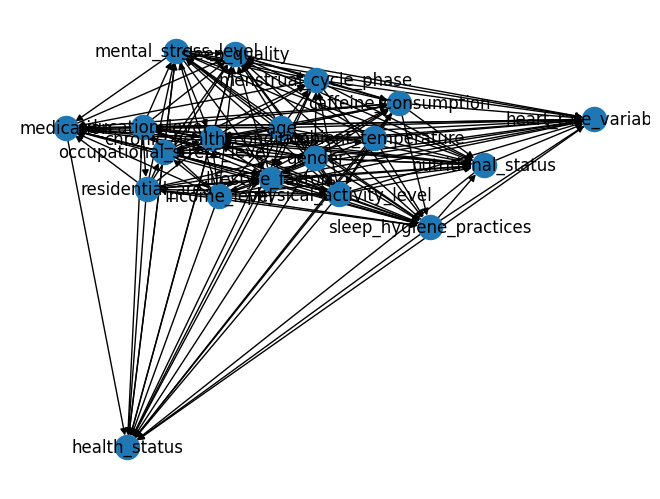

In [4]:
import networkx as nx

g = nx.DiGraph()
g.add_nodes_from(variable_names)
g.add_edges_from(relationships)

'''show graph'''
import matplotlib.pyplot as plt

nx.draw(g, with_labels=True)
plt.show()


In [8]:
from identifier_suggestor import IdentifierSuggestor 
from model_suggestor import ModelSuggestor
from typing import Dict, List, Tuple
from dotenv import load_dotenv
import dowhy
import guidance
import os
import re

load_dotenv()

api_key = os.getenv("api_key")
organization = os.getenv("organization")

# set the default language model used to execute guidance programs
gpt4 = guidance.llms.OpenAI(api_key=api_key, organization=organization, model="gpt-4")
gpt3 = guidance.llms.OpenAI(api_key=api_key, organization=organization, model="gpt-3.5-turbo-16k")
davinci = guidance.llms.OpenAI(api_key=api_key, organization=organization, model="text-davinci-003")
davinci2 = guidance.llms.OpenAI(api_key=api_key, organization=organization, model="davinci")    

c:\Users\t-rdesicilia\Documents\VSCodeProjects\Augment\askwhy_venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
identifier = IdentifierSuggestor()

In [2]:
variable_names = [
    "sleep_quality", 
    "heart_rate_variability", 
    "age", 
    "income_level", 
    "residential_area", 
    "medication", 
    "physical_activity_level", 
    "mental_stress_level", 
    "occupational_stress_level", 
    "ambient_temperature",
    "sleep_hygiene_practices",
    "chronic_health_conditions", 
    "menstrual_cycle_phase", 
    "health_status", 
    "lifestyle_factors", 
    "caffeine_consumption", 
    "nutritional_status", 
    "gender", 
    "education_level", 
]



In [3]:
relationships = [('sleep_quality', 'heart_rate_variability'),
('age', 'sleep_quality'),
('income_level', 'sleep_quality'),
('residential_area', 'sleep_quality'),
('medication', 'sleep_quality'),
('physical_activity_level', 'sleep_quality'),
('mental_stress_level', 'sleep_quality'),
('occupational_stress_level', 'sleep_quality'),
('ambient_temperature', 'sleep_quality'),
('sleep_hygiene_practices', 'sleep_quality'),
('chronic_health_conditions', 'sleep_quality'),
('menstrual_cycle_phase', 'sleep_quality'),
('sleep_quality', 'health_status'),
('lifestyle_factors', 'sleep_quality'),
('caffeine_consumption', 'sleep_quality'),
('nutritional_status', 'sleep_quality'),
('education_level', 'sleep_quality'),
('age', 'heart_rate_variability'),
('medication', 'heart_rate_variability'),
('physical_activity_level', 'heart_rate_variability'),
('mental_stress_level', 'heart_rate_variability'),
('occupational_stress_level', 'heart_rate_variability'),
('ambient_temperature', 'heart_rate_variability'),
('sleep_hygiene_practices', 'heart_rate_variability'),
('chronic_health_conditions', 'heart_rate_variability'),
('menstrual_cycle_phase', 'heart_rate_variability'),
('heart_rate_variability', 'health_status'),
('lifestyle_factors', 'heart_rate_variability'),
('caffeine_consumption', 'heart_rate_variability'),
('nutritional_status', 'heart_rate_variability'),
('age', 'income_level'),
('age', 'medication'),
('age', 'physical_activity_level'),
('age', 'mental_stress_level'),
('age', 'occupational_stress_level'),
('age', 'sleep_hygiene_practices'),
('age', 'chronic_health_conditions'),
('age', 'menstrual_cycle_phase'),
('age', 'health_status'),
('age', 'lifestyle_factors'),
('age', 'caffeine_consumption'),
('age', 'nutritional_status'),
('age', 'education_level'),
('income_level', 'heart_rate_variability'),
('income_level', 'residential_area'),
('income_level', 'medication'),
('income_level', 'physical_activity_level'),
('income_level', 'mental_stress_level'),
('income_level', 'occupational_stress_level'),
('income_level', 'sleep_hygiene_practices'),
('income_level', 'chronic_health_conditions'),
('income_level', 'health_status'),
('income_level', 'lifestyle_factors'),
('income_level', 'caffeine_consumption'),
('income_level', 'nutritional_status'),
('education_level', 'income_level'),
('residential_area', 'heart_rate_variability'),
('residential_area', 'medication'),
('residential_area', 'physical_activity_level'),
('residential_area', 'mental_stress_level'),
('residential_area', 'occupational_stress_level'),
('residential_area', 'ambient_temperature'),
('residential_area', 'sleep_hygiene_practices'),
('residential_area', 'chronic_health_conditions'),
('residential_area', 'health_status'),
('residential_area', 'lifestyle_factors'),
('residential_area', 'nutritional_status'),
('education_level', 'residential_area'),
('physical_activity_level', 'medication'),
('mental_stress_level', 'medication'),
('occupational_stress_level', 'medication'),
('ambient_temperature', 'medication'),
('medication', 'sleep_hygiene_practices'),
('chronic_health_conditions', 'medication'),
('menstrual_cycle_phase', 'medication'),
('medication', 'health_status'),
('lifestyle_factors', 'medication'),
('medication', 'nutritional_status'),
('gender', 'medication'),
('physical_activity_level', 'mental_stress_level'),
('occupational_stress_level', 'physical_activity_level'),
('ambient_temperature', 'physical_activity_level'),
('physical_activity_level', 'sleep_hygiene_practices'),
('physical_activity_level', 'chronic_health_conditions'),
('physical_activity_level', 'menstrual_cycle_phase'),
('physical_activity_level', 'health_status'),
('lifestyle_factors', 'physical_activity_level'),
('caffeine_consumption', 'physical_activity_level'),
('physical_activity_level', 'nutritional_status'),
('education_level', 'physical_activity_level'),
('occupational_stress_level', 'mental_stress_level'),
('ambient_temperature', 'mental_stress_level'),
('mental_stress_level', 'sleep_hygiene_practices'),
('mental_stress_level', 'chronic_health_conditions'),
('mental_stress_level', 'menstrual_cycle_phase'),
('mental_stress_level', 'health_status'),
('mental_stress_level', 'lifestyle_factors'),
('mental_stress_level', 'caffeine_consumption'),
('mental_stress_level', 'nutritional_status'),
('education_level', 'mental_stress_level'),
('occupational_stress_level', 'sleep_hygiene_practices'),
('occupational_stress_level', 'chronic_health_conditions'),
('occupational_stress_level', 'menstrual_cycle_phase'),
('occupational_stress_level', 'health_status'),
('occupational_stress_level', 'lifestyle_factors'),
('occupational_stress_level', 'caffeine_consumption'),
('occupational_stress_level', 'nutritional_status'),
('education_level', 'occupational_stress_level'),
('ambient_temperature', 'occupational_stress_level'),
('ambient_temperature', 'sleep_hygiene_practices'),
('ambient_temperature', 'chronic_health_conditions'),
('ambient_temperature', 'health_status'),
('ambient_temperature', 'lifestyle_factors'),
('ambient_temperature', 'caffeine_consumption'),
('ambient_temperature', 'nutritional_status'),
('sleep_hygiene_practices', 'chronic_health_conditions'),
('sleep_hygiene_practices', 'health_status'),
('lifestyle_factors', 'sleep_hygiene_practices'),
('caffeine_consumption', 'sleep_hygiene_practices'),
('sleep_hygiene_practices', 'nutritional_status'),
('education_level', 'sleep_hygiene_practices'),
('chronic_health_conditions', 'menstrual_cycle_phase'),
('chronic_health_conditions', 'health_status'),
('lifestyle_factors', 'chronic_health_conditions'),
('caffeine_consumption', 'chronic_health_conditions'),
('chronic_health_conditions', 'nutritional_status'),
('education_level', 'chronic_health_conditions'),
('menstrual_cycle_phase', 'sleep_hygiene_practices'),
('menstrual_cycle_phase', 'health_status'),
('menstrual_cycle_phase', 'lifestyle_factors'),
('menstrual_cycle_phase', 'caffeine_consumption'),
('menstrual_cycle_phase', 'nutritional_status'),
('gender', 'menstrual_cycle_phase'),
('lifestyle_factors', 'health_status'),
('caffeine_consumption', 'health_status'),
('nutritional_status', 'health_status'),
('gender', 'health_status'),
('education_level', 'health_status'),
('lifestyle_factors', 'caffeine_consumption'),
('lifestyle_factors', 'nutritional_status'),
('education_level', 'lifestyle_factors'),
('caffeine_consumption', 'medication'),
('caffeine_consumption', 'nutritional_status'),
('nutritional_status', 'education_level'),
('gender', 'sleep_quality'),
('gender', 'heart_rate_variability'),
('gender', 'income_level'),
('gender', 'physical_activity_level'),
('gender', 'mental_stress_level'),
('gender', 'occupational_stress_level'),
('gender', 'sleep_hygiene_practices'),
('gender', 'chronic_health_conditions'),
('gender', 'lifestyle_factors'),
('gender', 'caffeine_consumption'),
('gender', 'nutritional_status'),
('gender', 'education_level'),
('education_level', 'heart_rate_variability'),
('education_level', 'medication'),
('education_level', 'caffeine_consumption')]

In [4]:
backdoor = identifier.suggest_backdoor(llm=gpt4, variable_relationships=relationships, treatment="sleep_quality", outcome="heart_rate_variability")

Stop program system You are a causal inference expert and your task is to identify the backdoor set for a specific causal relationship in a directed acyclic graph (DAG). The DAG is represented as a list of edges, where each edge represents a causal relationship between two variables. Your task is to provide me with the backdoor set for a given causal relationship.

 The backdoor set for a causal relationship in a DAG is defined as a set of variables that satisfies two conditions:

 1. It blocks all directed paths from the treatment variable to the outcome variable.
 2. It does not contain any descendants of the treatment variable.

 To assist you, I will provide you with the causal relationship of interest and the DAG represented by a list of edges between variables.

 Your task if to provide me with the set of variables that satisfy the backdoor criterion for the given causal relationship, should any exist. 
 
 -----------------------------------------------------------------------------
 Input: 

 List of edges:
 (variable_1, variable_2)
 ...
 (variable_n, variable_m)

 Causal relationship of interest:
 treatment: variable_a
 outcome: variable_k

 Output:

 If backdoor set exists for the given causal relationship:
 <variable>variable_1</variable>
 ...
 <variable>variable_n</variable>

 If no backdoor set exists for the given causal relationship:
 <null> user List of edges:
 [('sleep_quality', 'heart_rate_variability'), ('age', 'sleep_quality'), ('income_level', 'sleep_quality'), ('residential_area', 'sleep_quality'), ('medication', 'sleep_quality'), ('physical_activity_level', 'sleep_quality'), ('mental_stress_level', 'sleep_quality'), ('occupational_stress_level', 'sleep_quality'), ('ambient_temperature', 'sleep_quality'), ('sleep_hygiene_practices', 'sleep_quality'), ('chronic_health_conditions', 'sleep_quality'), ('menstrual_cycle_phase', 'sleep_quality'), ('sleep_quality', 'health_status'), ('lifestyle_factors', 'sleep_quality'), ('caffeine_consumption', 'sleep_quality'), ('nutritional_status', 'sleep_quality'), ('education_level', 'sleep_quality'), ('age', 'heart_rate_variability'), ('medication', 'heart_rate_variability'), ('physical_activity_level', 'heart_rate_variability'), ('mental_stress_level', 'heart_rate_variability'), ('occupational_stress_level', 'heart_rate_variability'), ('ambient_temperature', 'heart_rate_variability'), ('sleep_hygiene_practices', 'heart_rate_variability'), ('chronic_health_conditions', 'heart_rate_variability'), ('menstrual_cycle_phase', 'heart_rate_variability'), ('heart_rate_variability', 'health_status'), ('lifestyle_factors', 'heart_rate_variability'), ('caffeine_consumption', 'heart_rate_variability'), ('nutritional_status', 'heart_rate_variability'), ('age', 'income_level'), ('age', 'medication'), ('age', 'physical_activity_level'), ('age', 'mental_stress_level'), ('age', 'occupational_stress_level'), ('age', 'sleep_hygiene_practices'), ('age', 'chronic_health_conditions'), ('age', 'menstrual_cycle_phase'), ('age', 'health_status'), ('age', 'lifestyle_factors'), ('age', 'caffeine_consumption'), ('age', 'nutritional_status'), ('age', 'education_level'), ('income_level', 'heart_rate_variability'), ('income_level', 'residential_area'), ('income_level', 'medication'), ('income_level', 'physical_activity_level'), ('income_level', 'mental_stress_level'), ('income_level', 'occupational_stress_level'), ('income_level', 'sleep_hygiene_practices'), ('income_level', 'chronic_health_conditions'), ('income_level', 'health_status'), ('income_level', 'lifestyle_factors'), ('income_level', 'caffeine_consumption'), ('income_level', 'nutritional_status'), ('education_level', 'income_level'), ('residential_area', 'heart_rate_variability'), ('residential_area', 'medication'), ('residential_area', 'physical_activity_level'), ('residential_area', 'mental_stress_level'), ('residential_area', 'occupational_stress_level'), ('residential_area', 'ambient_temperature'), ('residential_area', 'sleep_hygiene_prac

In [16]:
from dowhy.causal_identifier.auto_identifier import construct_backdoor_estimand as cbe

cbe(treatment_name=["heart_rate_variability"], outcome_name=["sleep_quality"], common_causes=backdoor)

{'estimand': Derivative(Expectation(sleep_quality|income_level,age,gender,residential_area,education_level), [heart_rate_variability]),
 'assumptions': {'Unconfoundedness': 'If U→{heart_rate_variability} and U→sleep_quality then P(sleep_quality|heart_rate_variability,income_level,age,gender,residential_area,education_level,U) = P(sleep_quality|heart_rate_variability,income_level,age,gender,residential_area,education_level)'}}

In [5]:
frontdoor = identifier.suggest_frontdoor(llm=gpt4, variable_relationships=relationships, treatment="sleep_quality", outcome="heart_rate_variability")

Stop program system You are a helpful assistant with expertise in causal inference. Your task is to identify the frontdoor set for a specific causal relationship in a directed acyclic graph (DAG). The DAG is represented as a list of edges, where each edge represents a causal relationship between two variables. Your task is to provide me with the frontdoor set for a given causal relationship.

 The frontdoor set for a causal relationship in a DAG is defined as a set of variables that satisfies the following conditions:

 1. It satisfies the frontdoor criterion, meaning it blocks all frontdoor paths from the causal variable to the outcome variable.
 2. It does not contain any colliders between the causal variable and the outcome variable.
 3. It is not affected by the outcome variable.
 
 -----------------------------------------------------------------------------
 Input: 

 List of edges:
 (variable_1, variable_2)
 ...
 (variable_n, variable_m)

 Causal relationship of interest:
 treatment: variable_a
 outcome: variable_k

 Output:

 If frontdoor set exists for the given causal relationship:
 <variable>variable_1</variable>
 ...
 <variable>variable_n</variable>

 If no frontdoor set exists for the given causal relationship:
 <null> user List of edges:
 [('sleep_quality', 'heart_rate_variability'), ('age', 'sleep_quality'), ('income_level', 'sleep_quality'), ('residential_area', 'sleep_quality'), ('medication', 'sleep_quality'), ('physical_activity_level', 'sleep_quality'), ('mental_stress_level', 'sleep_quality'), ('occupational_stress_level', 'sleep_quality'), ('ambient_temperature', 'sleep_quality'), ('sleep_hygiene_practices', 'sleep_quality'), ('chronic_health_conditions', 'sleep_quality'), ('menstrual_cycle_phase', 'sleep_quality'), ('sleep_quality', 'health_status'), ('lifestyle_factors', 'sleep_quality'), ('caffeine_consumption', 'sleep_quality'), ('nutritional_status', 'sleep_quality'), ('education_level', 'sleep_quality'), ('age', 'heart_rate_variability'), ('medication', 'heart_rate_variability'), ('physical_activity_level', 'heart_rate_variability'), ('mental_stress_level', 'heart_rate_variability'), ('occupational_stress_level', 'heart_rate_variability'), ('ambient_temperature', 'heart_rate_variability'), ('sleep_hygiene_practices', 'heart_rate_variability'), ('chronic_health_conditions', 'heart_rate_variability'), ('menstrual_cycle_phase', 'heart_rate_variability'), ('heart_rate_variability', 'health_status'), ('lifestyle_factors', 'heart_rate_variability'), ('caffeine_consumption', 'heart_rate_variability'), ('nutritional_status', 'heart_rate_variability'), ('age', 'income_level'), ('age', 'medication'), ('age', 'physical_activity_level'), ('age', 'mental_stress_level'), ('age', 'occupational_stress_level'), ('age', 'sleep_hygiene_practices'), ('age', 'chronic_health_conditions'), ('age', 'menstrual_cycle_phase'), ('age', 'health_status'), ('age', 'lifestyle_factors'), ('age', 'caffeine_consumption'), ('age', 'nutritional_status'), ('age', 'education_level'), ('income_level', 'heart_rate_variability'), ('income_level', 'residential_area'), ('income_level', 'medication'), ('income_level', 'physical_activity_level'), ('income_level', 'mental_stress_level'), ('income_level', 'occupational_stress_level'), ('income_level', 'sleep_hygiene_practices'), ('income_level', 'chronic_health_conditions'), ('income_level', 'health_status'), ('income_level', 'lifestyle_factors'), ('income_level', 'caffeine_consumption'), ('income_level', 'nutritional_status'), ('education_level', 'income_level'), ('residential_area', 'heart_rate_variability'), ('residential_area', 'medication'), ('residential_area', 'physical_activity_level'), ('residential_area', 'mental_stress_level'), ('residential_area', 'occupational_stress_level'), ('residential_area', 'ambient_temperature'), ('residential_area', 'sleep_hygiene_practices'), ('residential_area', 'chronic_health_conditions'), ('residential_area', 'health_status'), ('residential_area', 'lifes

In [19]:
from dowhy.causal_identifier.auto_identifier import construct_frontdoor_estimand as cfe

cfe(treatment_name=["heart_rate_variability"], outcome_name=["sleep_quality"], frontdoor_variables_names=frontdoor)

{'estimand': Expectation(Derivative(sleep_quality, [income_level, menstrual_cycle_phase, nutritional_status, caffeine_consumption, medication, age, lifestyle_factors, physical_activity_level, gender, residential_area, occupational_stress_level, mental_stress_level, chronic_health_conditions, ambient_temperature, education_level, sleep_hygiene_practices])*Derivative([income_level, menstrual_cycle_phase, nutritional_status, caffeine_consumption, medication, age, lifestyle_factors, physical_activity_level, gender, residential_area, occupational_stress_level, mental_stress_level, chronic_health_conditions, ambient_temperature, education_level, sleep_hygiene_practices], [heart_rate_variability])),
 'assumptions': {'Full-mediation': 'income_level,menstrual_cycle_phase,nutritional_status,caffeine_consumption,medication,age,lifestyle_factors,physical_activity_level,gender,residential_area,occupational_stress_level,mental_stress_level,chronic_health_conditions,ambient_temperature,education_leve

In [20]:
ivs = identifier.suggest_iv(llm=gpt4, variable_relationships=relationships, treatment="sleep_quality", outcome="heart_rate_variability")

Stop program system You are a helpful assistant with expertise in causal inference. Your task is to identify the instrumental variables causing the treatment in a specific causal relationship in a directed acyclic graph (DAG), where the DAG is represented as a list of edges, where each edge denotes a causal relationship between two variables. 

 In the field of causal inference, instrumental variables play a crucial role in estimating causal effects when facing unobserved confounding.
 Instrumental variables are defined as variables that satisfy the following conditions:

 1. They cause the treatment variable of interest.
 2. They are not caused by the outcome variable.
 3. They only affect the outcome variable indirectly through their effect on the treatment variable, they have no direct effect on the outcome variable.
 4. They are not caused by any confounders of the causal relationship of interest.
 
 -----------------------------------------------------------------------------
 Input: 

 List of edges:
 (variable_1, variable_2)
 ...
 (variable_n, variable_m)

 Causal relationship of interest:
 treatment: variable_a
 outcome: variable_k

 Output:

 If instrumental variable exists for the given causal relationship:
 <variable>variable_1</variable>

 If instrumental variables exist for the given causal relationship:
 <variable>variable_1</variable>
 ...
 <variable>variable_n</variable>

 If no instrumental variable exists for the given causal relationship:
 <null> user List of edges:
 [('sleep_quality', 'heart_rate_variability'), ('age', 'sleep_quality'), ('income_level', 'sleep_quality'), ('residential_area', 'sleep_quality'), ('medication', 'sleep_quality'), ('physical_activity_level', 'sleep_quality'), ('mental_stress_level', 'sleep_quality'), ('occupational_stress_level', 'sleep_quality'), ('ambient_temperature', 'sleep_quality'), ('sleep_hygiene_practices', 'sleep_quality'), ('chronic_health_conditions', 'sleep_quality'), ('menstrual_cycle_phase', 'sleep_quality'), ('sleep_quality', 'health_status'), ('lifestyle_factors', 'sleep_quality'), ('caffeine_consumption', 'sleep_quality'), ('nutritional_status', 'sleep_quality'), ('education_level', 'sleep_quality'), ('age', 'heart_rate_variability'), ('medication', 'heart_rate_variability'), ('physical_activity_level', 'heart_rate_variability'), ('mental_stress_level', 'heart_rate_variability'), ('occupational_stress_level', 'heart_rate_variability'), ('ambient_temperature', 'heart_rate_variability'), ('sleep_hygiene_practices', 'heart_rate_variability'), ('chronic_health_conditions', 'heart_rate_variability'), ('menstrual_cycle_phase', 'heart_rate_variability'), ('heart_rate_variability', 'health_status'), ('lifestyle_factors', 'heart_rate_variability'), ('caffeine_consumption', 'heart_rate_variability'), ('nutritional_status', 'heart_rate_variability'), ('age', 'income_level'), ('age', 'medication'), ('age', 'physical_activity_level'), ('age', 'mental_stress_level'), ('age', 'occupational_stress_level'), ('age', 'sleep_hygiene_practices'), ('age', 'chronic_health_conditions'), ('age', 'menstrual_cycle_phase'), ('age', 'health_status'), ('age', 'lifestyle_factors'), ('age', 'caffeine_consumption'), ('age', 'nutritional_status'), ('age', 'education_level'), ('income_level', 'heart_rate_variability'), ('income_level', 'residential_area'), ('income_level', 'medication'), ('income_level', 'physical_activity_level'), ('income_level', 'mental_stress_level'), ('income_level', 'occupational_stress_level'), ('income_level', 'sleep_hygiene_practices'), ('income_level', 'chronic_health_conditions'), ('income_level', 'health_status'), ('income_level', 'lifestyle_factors'), ('income_level', 'caffeine_consumption'), ('income_level', 'nutritional_status'), ('education_level', 'income_level'), ('residential_area', 'heart_rate_variability'), ('residential_area', 'medication'), ('residential_area', 'physical_activity_level'), ('residential_area', 'mental_stress_level'), ('residential_area', 'oc

In [21]:
from dowhy.causal_identifier.auto_identifier import construct_iv_estimand as cie

cie(treatment_name=["heart_rate_variability"], outcome_name=["sleep_quality"], instrument_names=ivs)

{'estimand': Expectation(Derivative(sleep_quality, [income_level, menstrual_cycle_phase, nutritional_status, caffeine_consumption, medication, age, lifestyle_factors, physical_activity_level, gender, residential_area, occupational_stress_level, mental_stress_level, chronic_health_conditions, ambient_temperature, education_level, sleep_hygiene_practices])*Derivative([heart_rate_variability], [income_level, menstrual_cycle_phase, nutritional_status, caffeine_consumption, medication, age, lifestyle_factors, physical_activity_level, gender, residential_area, occupational_stress_level, mental_stress_level, chronic_health_conditions, ambient_temperature, education_level, sleep_hygiene_practices])**(-1)),
 'assumptions': {'As-if-random': 'If U→→sleep_quality then ¬(U →→{income_level,menstrual_cycle_phase,nutritional_status,caffeine_consumption,medication,age,lifestyle_factors,physical_activity_level,gender,residential_area,occupational_stress_level,mental_stress_level,chronic_health_condition